## Step 1 : Preparing the DataSet

In [1]:
import json
import os
import urllib.request
import ssl

# Define the file path in Colab's default directory
file_path = "/content/instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    # Download only if the file doesn't exist
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")

        # Debugging: Print first 200 characters to check the content
        print("Downloaded Content Preview:\n", text_data[:200])

        # Save the file
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # Load the JSON file
    with open(file_path, "r", encoding="utf-8") as file:
        try:
            data = json.load(file)
        except json.JSONDecodeError:
            print("Error: The file is not a valid JSON.")
            file.seek(0)
            print("First few lines of the file:\n", file.read(200))
            return None

    return data

# Run the function
data = download_and_load_file(file_path, url)

# Check if data was successfully loaded
if data:
    print("Number of Entries:", len(data))
else:
    print("Failed to load JSON. Check the downloaded content.")


Downloaded Content Preview:
 [
    {
        "instruction": "Evaluate the following phrase by transforming it into the spelling given.",
        "input": "freind --> friend",
        "output": "The spelling of the given phrase \"
Number of Entries: 1100


In [2]:
print( "Example Entry : " , data[24])

Example Entry :  {'instruction': 'Convert this sentence to passive voice', 'input': 'The chef cooked a delicious meal.', 'output': 'A delicious meal was cooked by the chef.'}


In [3]:
# We will use the Alpha Prompt Fromat for fine tuning using the json file
#-> Called Aplaca Style

#converting the instructions into Alpha Format
def format_input( entry ):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f" Write a response that appropiately completes the request."
        f"\n\n### Instruction:\n{ entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

In [4]:
model_input = format_input( data[999])

desired_reponse = f"\n\n### Response:\n{ data[999]['output']}"
print( model_input + desired_reponse )

Below is an instruction that describes a task. Write a response that appropiately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [5]:
#Spliting the Data Set for Train-Test-Validation
train_portion = int(len( data ) * 0.85 )
test_portion = int( len( data ) * 0.1 )
val_portion =  len( data ) - train_portion - test_portion

train_data = data[:train_portion ]
test_data = data[ train_portion : train_portion + test_portion ]
val_data= data[ train_portion + test_portion :]

In [6]:
print("Training set length : " , len( train_data ))
print("validation set length : " , len( val_data ))
print("Test set length : " , len( test_data ))

Training set length :  935
validation set length :  55
Test set length :  110


## Batching the DataSet

In [7]:
# Converting the whole input to token ids

from torch.utils.data import Dataset

class InstructionDataset( Dataset ):
    def __init__( self , data , tokenizer ):
        self.data = data

        #pre tokeinize text
        self.encoded_texts = []
        for entry in data :
            instruction_plus_input = format_input( entry )
            response_text = f"\n\n### Response:\n{ entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append( tokenizer.encode( full_text ))



    def __getitem__(self, index):
        return self.encoded_texts[ index ]

    def __len__( self ):
        return len( self.data)

In [8]:
!pip install tiktoken
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print( tokenizer.encode("<|endoftext|>" , allowed_special= {"<|endoftext|>"}) )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.2 MB/s eta 0:00:00
[50256]


Step 1 : Find the longest input length in the batch.

Step 2 : Pad and prepare the inputs.

Step 3 : Remove the extra padded token added earlier.

Step 4 : convert the list of input to tensor and transfer to target device.


In [9]:
import torch

def custom_collate_draft_1(  batch , pad_toke_id = 50256 , device = "cpu" ):
    # Find the longest length in the batch and add it by 1

    batch_max_length = max( len( item ) + 1 for item in batch )

    # Pad and prepare inputs
    input_lst = []


    for item in batch :
        new_item = item.copy()
        new_item += [pad_toke_id ]
        padded = (
            new_item + [ pad_toke_id ] * ( batch_max_length - len( new_item ))

        )
        inputs = torch.tensor( padded[: -1 ])
        input_lst.append( inputs )

    # convert the input list to tensor and transfer to target
    inputs_tensor = torch.stack( input_lst ).to( device )
    return inputs_tensor



In [10]:
inputs_1 = [ 0, 1 , 2, 3, 4 ]
inputs_2 = [ 5, 6 ]
inputs_3 = [ 7 , 8 , 9 ]

batch = (
    inputs_1 , inputs_2 , inputs_3
)
print( custom_collate_draft_1( batch ))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


### Creating the Token Ids for targets

In [11]:
def custom_collate_draft_2( batch , pad_toke_id = 50256 , device = "cpu" ):
    # Find the longest length in the batch and add it by 1

    batch_max_length = max( len( item ) + 1 for item in batch )

    # Pad and prepare inputs
    input_lst, target_lst  = [], []


    for item in batch :
        new_item = item.copy()
        new_item += [pad_toke_id ]
        padded = (
            new_item + [ pad_toke_id ] * ( batch_max_length - len( new_item ))

        )
        inputs = torch.tensor( padded[: -1 ])
        targets = torch.tensor( padded[ 1 : ])
        input_lst.append( inputs )
        target_lst.append( targets )

    #Convert the List of inputs to tensor and transfer to target device
    input_tensor = torch.stack( input_lst ).to( device )
    target_tensor = torch.stack( target_lst ).to( device )
    return input_tensor , target_tensor



In [12]:
inputs_1 = [ 0, 1 , 2, 3, 4 ]
inputs_2 = [ 5, 6 ]
inputs_3 = [ 7 , 8 , 9 ]

batch = (
    inputs_1 , inputs_2 , inputs_3
)
inputs , targets = custom_collate_draft_2( batch )
print( inputs )
print( targets )

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [13]:
#In the Next Step we will replace Padding token with -100 so that it does not contribute in the training loss
#but retaining the one 505256 token as the mark of end of text token


def custom_collate_fn( batch , pad_token_id = 50256 , ignore_index = -100 , allowed_max_length = None , device = "cpu" ):
    # Find the longest length in the batch and add it by 1

    batch_max_length = max( len( item ) + 1 for item in batch )

    # Pad and prepare inputs
    input_lst, target_lst  = [], []


    for item in batch :
        new_item = item.copy()
        new_item += [pad_token_id ]
        padded = (
            new_item + [ pad_token_id ] * ( batch_max_length - len( new_item ))

        )
        inputs = torch.tensor( padded[: -1 ])
        targets = torch.tensor( padded[ 1 : ])


        #Replace all but the first padding token with the ignore index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[ indices[1 : ]] = ignore_index


        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None :
            inputs = inputs[ : allowed_max_length ]
            targets = targets[: allowed_max_length ]

        input_lst.append( inputs )
        target_lst.append( targets )


    #Convert the List of inputs to tensor and transfer to target device
    input_tensor = torch.stack( input_lst ).to( device )
    target_tensor = torch.stack( target_lst ).to( device )
    return input_tensor , target_tensor


In [14]:
inputs_1 = [ 0, 1 , 2, 3, 4 ]
inputs_2 = [ 5, 6 ]
inputs_3 = [ 7 , 8 , 9 ]

batch = (
    inputs_1 , inputs_2 , inputs_3
)
inputs , targets = custom_collate_fn( batch )
print( inputs )
print( targets )

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [15]:
#The prupose of doing the target paddimg token of 50256 with -100
# The Demo for that
logits_1 = torch.tensor(
    [[ -1.0 , 1.0 ],
     [ -0.5 , 1.5 ]]
)
targets_1 = torch.tensor( [ 0 , 1 ])
loss_1 = torch.nn.functional.cross_entropy( logits_1 , targets_1 )
print( loss_1 )

tensor(1.1269)


In [16]:
logits_2 = torch.tensor(
    [[ -1.0 , 1.0 ],
     [ -0.5 , 1.5 ],
     [ -0.5 , 1.5 ]]
)
targets_2 = torch.tensor( [ 0 , 1, 1 ])
loss_2 = torch.nn.functional.cross_entropy( logits_2 , targets_2 )
print( loss_2 )

tensor(0.7936)


In [17]:
targets_3 = torch.tensor( [ 0 , 1 , -100 ])

loss_3 = torch.nn.functional.cross_entropy( logits_2 , targets_3 )

print( loss_3 )
print( "Loss 1 == Loss 3 " , loss_1 == loss_3 )

tensor(1.1269)
Loss 1 == Loss 3  tensor(True)


## Creating the Data Loaders

In [18]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "mps")
print( "Device : ", device )

Device :  cuda


In [19]:
from functools import partial
custom_collate_fn = partial( custom_collate_fn , device = device , allowed_max_length = 1024 )


In [20]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed( 123 )

train_dataset = InstructionDataset( train_data , tokenizer )
train_loader = DataLoader(
    train_dataset ,
    batch_size = batch_size ,
    collate_fn= custom_collate_fn,
    shuffle= True ,
    drop_last= True,
    num_workers= num_workers
)

val_dataset = InstructionDataset( val_data , tokenizer )
val_loader = DataLoader(
    val_dataset ,
    batch_size = batch_size ,
    collate_fn= custom_collate_fn ,
    shuffle= False ,
    drop_last= False ,
    num_workers= num_workers
)

test_dataset = InstructionDataset( test_data , tokenizer )
test_loader = DataLoader(
    test_dataset ,
    batch_size = batch_size ,
    collate_fn= custom_collate_fn ,
    shuffle= False ,
    drop_last= False ,
    num_workers= num_workers
)

In [21]:
print("Train Loader : ")
for inputs , targets in train_loader :
    print( inputs.shape , targets.shape )

Train Loader : 
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 70]) torc

## Loading The Pretrain Model

In [22]:
import torch
import torch.nn as nn

### Layer Normalisation and Feed Forward Neural Network
class LayerNorm( nn.Module ):
    def __init__( self , emb_dim ):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter( torch.ones( emb_dim ))
        self.shift = nn.Parameter( torch.zeros( emb_dim ))


    def forward( self , x ):
        mean = x.mean( dim = -1 , keepdim = True )
        var = x.var( dim = -1 , keepdim = True , unbiased = True )
        norm_x = ( x - mean ) / torch.sqrt( var + self.eps )
        return self.scale * norm_x + self.shift


class GELU( nn.Module ):
    def __init__( self  ):
        super().__init__()

    def forward( self , x ):
        return 0.5 * x * ( 1 + torch.tanh(
            torch.sqrt( torch.tensor( 2.0 / torch.pi )) *
            ( x + 0.044715 * torch.pow( x , 3 ))
        ))

class FeedForward( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear( cfg["emb_dim" ] , 4 * cfg["emb_dim" ] ),
            GELU(),
            nn.Linear( 4 * cfg[ "emb_dim"] , cfg[ "emb_dim" ]),

        )

    def forward( self , x ):
        return self.layers( x )

In [23]:
### MutiHead Attention Mech
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [24]:
### Transformer Class
class TransformerBlock( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg[ "emb_dim"],
            d_out = cfg[ "emb_dim"],
            context_length = cfg[ "context_length"],
            num_heads = cfg[ "n_heads"],
            dropout = cfg[ "drop_rate"],
            qkv_bias = cfg[ "qkv_bias"],

        )
        self.ff = FeedForward( cfg )
        self.norm1 = LayerNorm( cfg[ "emb_dim"])
        self.norm2 = LayerNorm( cfg[ "emb_dim"])
        self.drop_shortcut = nn.Dropout( cfg["drop_rate"])

    def forward( self , x ):
        shortcut = x
        x = self.norm1( x )
        x = self.att( x )
        x = self.drop_shortcut( x )
        x = x + shortcut

        shortcut = x
        x = self.norm2( x )
        x = self.ff( x )
        x = self.drop_shortcut( x )
        x = x + shortcut


        return x

In [25]:
### Now to Code the GPT Architecture
class GPTModel( nn.Module ):
    def __init__(self , cfg ):
        super().__init__()
        self.tok_emb = nn.Embedding( cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding( cfg["context_length" ] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout( cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock( cfg ) for _ in range(cfg[ "n_layers"])])

        self.final_norm = LayerNorm( cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"] , cfg[ "vocab_size"], bias=  False
        )
        self.device = None

    def forward( self , in_idx ):
        batch_size, seq_len = in_idx.shape
        if self.device :
          in_idx = in_idx.to( self.device )
        tok_embeds = self.tok_emb( in_idx )
        pos_embeds = self.pos_emb( torch.arange( seq_len , device = in_idx.device ))
        x = tok_embeds + pos_embeds
        x = self.drop_emb( x )
        x = self.trf_blocks( x )
        x = self.final_norm( x )
        logits = self.out_head( x )
        return logits

    def to(self, *args, **kwargs):
        """Override the to() method to store the device."""
        self = super().to(*args, **kwargs)
        self.device = args[0] if args else kwargs.get('device')
        return self

In [26]:
def text_to_token_ids( text , tokenizer ):
    encoded = tokenizer.encode( text , allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
    return encoded_tensor

def token_ids_to_text( token_ids , tokenizer ):
    flat = token_ids.squeeze( 0 )
    return tokenizer.decode( flat.tolist())

In [27]:
import tensorflow as tf
import tqdm

print( "Tensorflow version ", tf.__version__ )
print( "tqdm Version ", tqdm.__version__ )

Tensorflow version  2.18.0
tqdm Version  4.67.1


In [28]:
def assign( left , right ):
    if left.shape != right.shape:
        raise ValueError( f"Shape mismatched. Left: { left.shape } , Right : { right.shape }")

    return torch.nn.Parameter( torch.tensor( right ))

In [29]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [30]:
# For this fine tuning process we will use GPT - 2 355 M parameter model

from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True
}

model_configs = {
    "gpt2-small (124M)" : { "emb_dim" : 768 , "n_layers" : 12 , "n_heads" : 12 },
    "gpt2-medium (355M)" : { "emb_dim" : 1024 , "n_layers" : 24 , "n_heads" : 16 },
    "gpt2-large (774M)" : { "emb_dim" : 1280 , "n_layers" : 36 , "n_heads" : 20 },
    "gpt2-xl (1558M)" : { "emb_dim" : 1600 , "n_layers" : 48 , "n_heads" : 25 },
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update( model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings , params = download_and_load_gpt2( model_size= model_size , models_dir= "gpt2")
model = GPTModel( BASE_CONFIG )
load_weights_into_gpt( model , params )
model.eval()

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 164kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.37MiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [31]:
torch.manual_seed( 123 )
input_text = format_input( val_data[ 0 ])
print( input_text )

Below is an instruction that describes a task. Write a response that appropiately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [32]:
def generate_text_sample( model , idx , max_new_tokens , context_size ):
    # idx is the ( batch , n_tokens ) array of the indices in the current context
    for _ in range( max_new_tokens ):
        idx_cond = idx[:, -context_size: ]
        with torch.no_grad():
            logits = model( idx_cond )

        logits = logits[ :, -1, :]

        probas = torch.softmax( logits , dim = -1 )

        idx_next = torch.argmax( probas , dim = -1 , keepdim = True )

        idx = torch.cat((idx , idx_next ), dim = 1 )

    return idx

def generate( model , idx , max_new_tokens , context_size , temperarture = 0.0 , top_k = None , eos_id = None ):

    idx = idx.to( model.device)
    for _ in range( max_new_tokens ):
        idx_cond = idx[ :, -context_size:]
        with torch.no_grad():
            logits = model( idx_cond )
        logits = logits[ :, -1, : ]

        if top_k is not None :
            # Keep only top k values
            top_logits, _ = torch.topk( logits , top_k )
            min_val = top_logits[ : ,-1 ]
            logits = torch.where( logits < min_val , torch.tensor( float("-inf")).to(logits.device ) , logits )

        if temperarture > 0.0 :
            logits = logits / temperarture

            # Apply softmax to get the probability
            probas = torch.softmax( logits , dim = -1 )

            idx_next = torch.multinomial( probas , num_samples = 1 )

        else:
            idx_next = torch.argmax( logits , dim = -1 , keepdim = True )

        if idx_next == eos_id :
            break

        idx = torch.cat(( idx , idx_next ) , dim = 1 )

    return idx

In [33]:
token_ids = generate(
    model = model ,
    idx = text_to_token_ids( input_text , tokenizer ) ,
    max_new_tokens = 35 ,
    context_size = BASE_CONFIG["context_length"],
    eos_id  = 50256,
      )

generated_text = token_ids_to_text( token_ids , tokenizer)


In [34]:
response_text = generated_text[ len( input_text ):].strip()
print( response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Fine Tuning the LLM on the Instruction Data

In [35]:

def calc_loss_batch( input_batch , target_batch , model , device ):
    input_batch , target_batch = input_batch.to( device ) , target_batch.to( device )

    logits = model( input_batch )
    loss = torch.nn.functional.cross_entropy( logits.flatten( 0 , 1 ) , target_batch.flatten())
    return loss

def calc_loss_loader( data_loader , model , device , num_batches = None ):
    total_loss = 0

    if( len( data_loader ) == 0 ):
        return float("nan")
    elif num_batches is None :
        num_batches = len( data_loader )

    else :
        num_batches = min( num_batches , len( data_loader ))

    for i , ( input_batch , target_batch ) in enumerate( data_loader ):
        if i < num_batches:
            loss = calc_loss_batch( input_batch , target_batch , model , device )
            total_loss += loss.item()

        else :
            break

    return total_loss / num_batches


def evaluate_model( model , train_loader , val_loader , device , eval_iter ):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader( train_loader , model , device , num_batches= eval_iter )
        val_loss = calc_loss_loader( val_loader , model , device , num_batches= eval_iter )
    model.train()
    return train_loss , val_loss

In [36]:
def generate_and_print_sample( model , tokenizer , device , start_context ):
    model.eval()
    context_size = model.pos_emb.weight.shape[ 0 ]
    encoded = text_to_token_ids( start_context , tokenizer ).to( device )
    with torch.no_grad():
        token_ids = generate_text_sample(
            model = model ,
            idx = encoded ,
            max_new_tokens= 50 ,
            context_size= context_size
        )
    decoded_text = token_ids_to_text( token_ids , tokenizer )
    print( decoded_text.replace("\n" , " ")) #compact print format
    model.train()

In [37]:
# The preatrained model is able to proecess and give correct output of the intsruction provided by us

def train_model_simple( model , train_loader , val_loader , optimizer , device , num_epochs , eval_freq , eval_iter , start_context , tokenizer ):

    train_losses , val_losses , track_tokens_seen = [] , [] , []
    tokens_seen , global_step = 0 , -1

    #Main Training Loops
    for epoch in range( num_epochs ):
        model.train() # Setting the model in training mode

        for input_batch , target_batch in train_loader :
            optimizer.zero_grad()
            loss = calc_loss_batch( input_batch , target_batch , model , device )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            #optional evaluation step
            if global_step % eval_freq == 0 :
                train_loss , val_loss = evaluate_model(
                    model , train_loader , val_loader , device , eval_iter
                )
                train_losses.append( train_loss )
                val_losses.append( val_loss )
                track_tokens_seen.append( tokens_seen )
                print( f"Ep { epoch + 1 } ( Step { global_step:06d}):"
                       f"Train Loss { train_loss:.3f} , Val Loss { val_loss:.3f}")

        #Print the Sample of text generated
        generate_and_print_sample(
            model , tokenizer , device , start_context
        )

    return train_losses , val_losses , track_tokens_seen


In [38]:
model.to( device )

torch.manual_seed( 123 )

with torch.no_grad():
    train_loss = calc_loss_loader( train_loader , model , device , num_batches= 5 )
    val_loss = calc_loss_loader( val_loader , model , device , num_batches= 5 )

print( "Training Loss : " , train_loss )
print( "Validation Loss : ", val_loss )

Training Loss :  3.893436241149902
Validation Loss :  3.827153968811035


In [39]:
import time

start_time = time.time()

torch.manual_seed( 123 )

optimizer = torch.optim.AdamW( model.parameters() , lr = 0.00005 , weight_decay= 0.1 )

num_epochs = 1

train_losses , val_losses , tokens_seen  = train_model_simple(
    model , train_loader , val_loader , optimizer , device ,
    num_epochs= num_epochs , eval_freq= 5 , eval_iter= 5 ,
    start_context= format_input( val_data[ 0 ]) , tokenizer= tokenizer
)

end_time = time.time()

execution_time_minutes = ( end_time - start_time ) / 60

print( f"Training Completed in {execution_time_minutes:.2f} minutes")


Ep 1 ( Step 000000):Train Loss 2.645 , Val Loss 2.632
Ep 1 ( Step 000005):Train Loss 1.147 , Val Loss 1.079
Ep 1 ( Step 000010):Train Loss 0.842 , Val Loss 0.915
Ep 1 ( Step 000015):Train Loss 0.822 , Val Loss 0.879
Ep 1 ( Step 000020):Train Loss 0.748 , Val Loss 0.851
Ep 1 ( Step 000025):Train Loss 0.724 , Val Loss 0.824
Ep 1 ( Step 000030):Train Loss 0.764 , Val Loss 0.799
Ep 1 ( Step 000035):Train Loss 0.694 , Val Loss 0.781
Ep 1 ( Step 000040):Train Loss 0.648 , Val Loss 0.777
Ep 1 ( Step 000045):Train Loss 0.611 , Val Loss 0.763
Ep 1 ( Step 000050):Train Loss 0.644 , Val Loss 0.758
Ep 1 ( Step 000055):Train Loss 0.737 , Val Loss 0.739
Ep 1 ( Step 000060):Train Loss 0.699 , Val Loss 0.721
Ep 1 ( Step 000065):Train Loss 0.634 , Val Loss 0.713
Ep 1 ( Step 000070):Train Loss 0.516 , Val Loss 0.707
Ep 1 ( Step 000075):Train Loss 0.551 , Val Loss 0.707
Ep 1 ( Step 000080):Train Loss 0.585 , Val Loss 0.701
Ep 1 ( Step 000085):Train Loss 0.494 , Val Loss 0.686
Ep 1 ( Step 000090):Train Lo

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses( epochs_seen , token_seen , train_losses , val_losses ):
    fig , ax1 = plt.subplots( figsize = ( 5 , 3 ))

    #plot Training and Validation losses against the epochs
    ax1.plot( epochs_seen , train_losses , label = "Training Loss")
    ax1.plot( epochs_seen , val_losses , linestyle = "-." ,  label = "Validation Loss" )

    ax1.set_xlabel( "Epochs")
    ax1.set_ylabel( "Loss" )
    ax1.legend( loc = "upper right")
    ax1.xaxis.set_major_locator( MaxNLocator( integer = True ))

    ax2 = ax1.twiny()
    ax2.plot( token_seen , train_losses , alpha = 0 )
    ax2.set_xlabel("Token_seen ")
    fig.tight_layout()
    plt.savefig("loss-plot-Instruction-FineTune.pdf")
    plt.show()

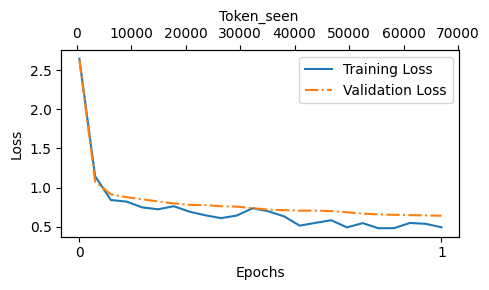

In [41]:
epochs_tensor = torch.linspace( 0 , num_epochs , len( train_losses ))
plot_losses( epochs_tensor , tokens_seen , train_losses , val_losses)

In [ ]:
# This Line plot actually coverges from value of loss = 2.3 to 0.3
# But I have run this code twice so the updatation of weights has been done twice so the values start converges from
#0.7 something


In [ ]:
# We can increase num of epochs to increase the accuracy of the model more


## Save the Model weights so that I can use in my local machine

In [ ]:
torch.save(model.state_dict(), 'fine_tuned_model_weights.pth')


## Extracting and Saving the Responses

In [ ]:
model.to( device )

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [42]:
# lets just first check the ouput generated by llm for 3 test dataset
print( device )
for entry in test_data[ : 3 ]:
  input_text = format_input( entry )


  token_ids = generate(
      model = model ,
      idx = text_to_token_ids( input_text , tokenizer ).to( device ) ,
      max_new_tokens = 256 ,
      context_size = BASE_CONFIG["context_length"],
      eos_id= 50256
  )

  generated_text = token_ids_to_text( token_ids , tokenizer )
  response_text = (
      generated_text[ len( input_text ):].
      replace( "### Response:" , "")
      .strip()
  )

  print( input_text )
  print( f"\n Correct Response: \n >>{ entry['output']}")
  print( f"\n Model Response: \n >>{ response_text.strip()}")
  print( "-------------------------------------------------")




cuda
Below is an instruction that describes a task. Write a response that appropiately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

 Correct Response: 
 >>The car is as fast as lightning.

 Model Response: 
 >>The car is very fast.
-------------------------------------------------
Below is an instruction that describes a task. Write a response that appropiately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

 Correct Response: 
 >>The type of cloud typically associated with thunderstorms is cumulonimbus.

 Model Response: 
 >>A thunderstorm is a type of cloud that typically occurs in the atmosphere.
-------------------------------------------------
Below is an instruction that describes a task. Write a response that appropiately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

 Correct Response: 
 >>Jane Austen.

 Model Response

In [43]:
# 3 ways to evaluate the chatbots based on llm

# We will use another LLM for evaluating the results between real and generated answer bu the Finetuned LLM


from tqdm import tqdm

for i , entry in tqdm( enumerate( test_data ) , total= len( test_data )):
    input_text = format_input( entry )

    token_ids = generate(
        model = model ,
        idx = text_to_token_ids( input_text , tokenizer ).to( device ) ,
        max_new_tokens = 256 ,
        context_size = BASE_CONFIG["context_length"],
        eos_id= 50256
    )

    generated_text = token_ids_to_text( token_ids , tokenizer )
    response_text = (
        generated_text[ len( input_text ):].
        replace( "### Response:" , "")
        .strip()
    )
    test_data[ i ][ "model_output" ] = response_text

with open("instruction-data-with-response.json" , "w") as file:
  json.dump( test_data , file , indent = 4 )

100%|██████████| 110/110 [01:21<00:00,  1.35it/s]


In [44]:
print( test_data[ 0 ])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_output': 'The car is very fast.'}


## Evaluating the Fine - Tune LLM using OLLAMA

In [46]:
# Donwload and install LLaMa 3 b in personal computer using OLLama
# And run in terminal


!pip install transformers accelerate torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "meta-llama/Llama-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

def generate_text(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_length=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generate_text("Hello, how are you?"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 874.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: meta-llama/Llama-3B is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
for entry in test_data[:3]:

  prompt = (
      f"Given the input `{ format_input( entry )}`"
      f"and correct output `{ entry['output']}`,"
      f"score the model reponse  `{ entry['model_response']}`"
      f"on scale of 0 to 100, where 100 is the best score."
  )

  print("\nDataset response:")
  print(">>", entry['output '])
  print("\nModel response:")
  print(">>", entry["model_response"])
  print ("\nScore:")
  print(">>", generate_text(prompt) )
  print ("\n-------------------------" )